1 degree of latitude = 111.19 km
1 degree of longitude at 37.5 N latitude = 88.22 km
Feature moves 43.20 km per 180 minutes
Feature moves 0.490 degrees longitude per 180 minutes

Starting simulation with 'X' shape gradient and 3-hour internal time steps (6-panel with zooms, reduced Y-range, SLOWER SPEED, CUMULATIVES PERSISTENT)...
Generated output frame 00000 at total simulated time 0.0 hours.
Generated output frame 00001 at total simulated time 3.0 hours.
Generated output frame 00002 at total simulated time 6.0 hours.
Generated output frame 00003 at total simulated time 9.0 hours.
Generated output frame 00004 at total simulated time 12.0 hours.
Generated output frame 00005 at total simulated time 15.0 hours.
Generated output frame 00006 at total simulated time 18.0 hours.
Generated output frame 00007 at total simulated time 21.0 hours.
Generated output frame 00008 at total simulated time 24.0 hours.
Generated output frame 00009 at total simulated time 27.0 hours.
Generated output fram

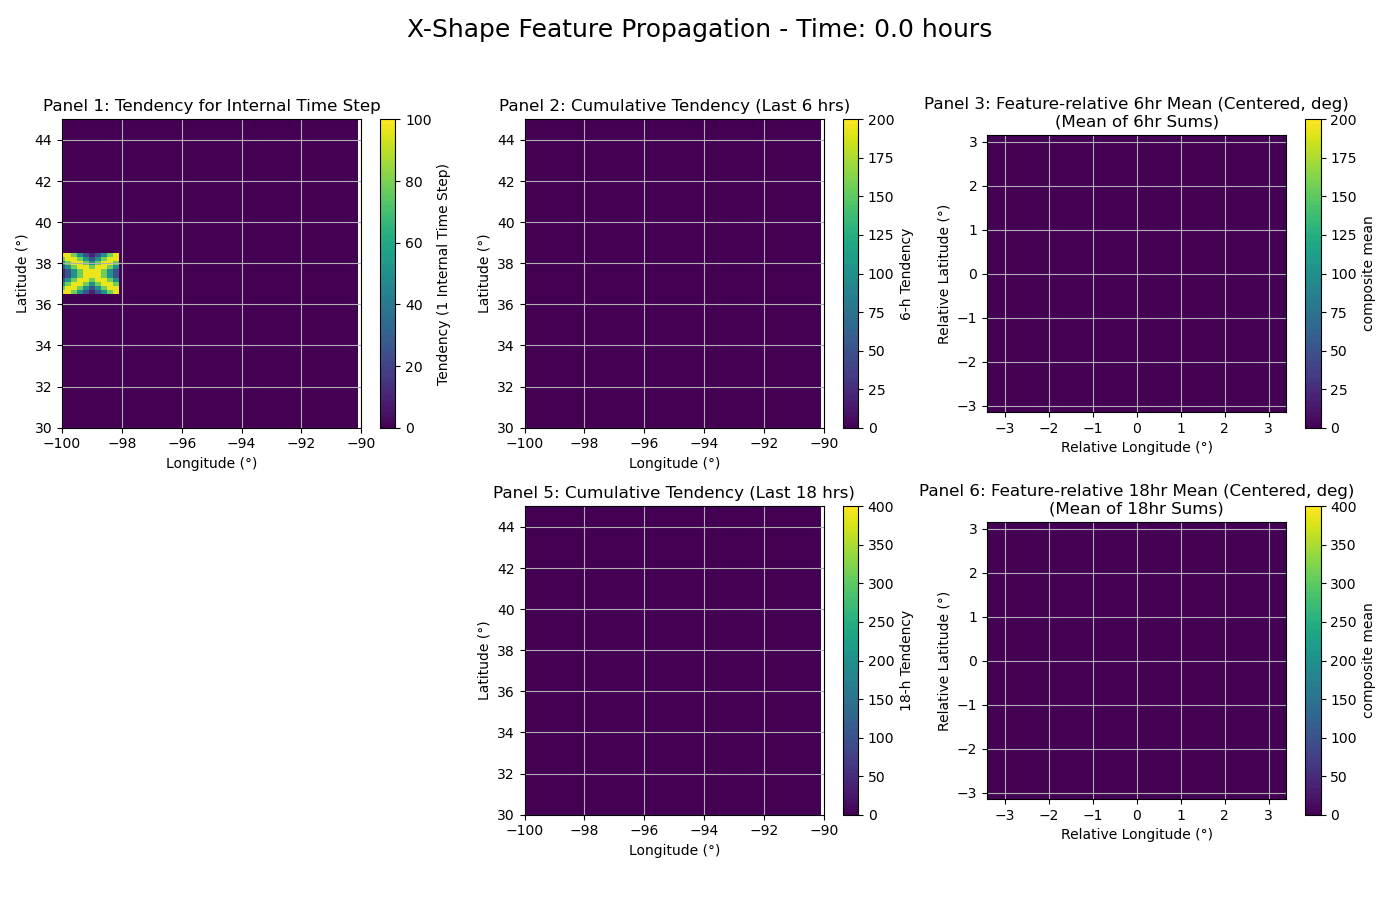

 magick -delay 50 -loop 0 x_shape_gradient_6panel_summed_Feature-relative_cartesian_persistent/frame_*.png x_shape_gradient_6panel_summed_Feature-relative_cartesian_persistent/x_shape_gradient_6panel_summed_Feature-relative_cartesian_persistent_propagation.gif


In [5]:
import os

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

# --- Constants ---
EARTH_RADIUS_KM = 6371  # Approximate Earth radius in kilometers
MS_TO_KMH = 3.6  # Conversion from m/s to km/h
SECONDS_PER_HOUR = 3600
MINUTES_PER_HOUR = 60

# --- Time Step Parameters ---
OUTPUT_FRAME_INTERVAL_MINUTES = 60  # Output a frame every 60 minutes (NOTE: Not used for actual frame generation frequency in loop)
INTERNAL_TIME_STEP_MINUTES = 180  # Internal calculation step is 180 minutes (3 hours) - INCREASED
INTERNAL_TIME_STEP_HOURS = INTERNAL_TIME_STEP_MINUTES / MINUTES_PER_HOUR

CUMULATIVE_6HR_INTERVAL_HOURS = 6
CUMULATIVE_18HR_INTERVAL_HOURS = 18

TOTAL_SIMULATION_HOURS = (
    200  # Max simulation time to prevent infinite loop (adjusted in previous steps)
)

# --- Plotting & Grid Boundaries (Unified) ---
PLOT_LON_WEST = -100.0
PLOT_LON_EAST = -90.0  # Eastern boundary
PLOT_LAT_SOUTH = 30.0
PLOT_LAT_NORTH = 45.0

# --- Grid Resolution ---
GRID_RESOLUTION_DEG = 0.2
# Grid now uses plot boundaries directly
# FIX: Change LONS definition to ensure plotting does not exceed PLOT_LON_EAST
LONS = np.arange(PLOT_LON_WEST, PLOT_LON_EAST, GRID_RESOLUTION_DEG)
LATS = np.arange(PLOT_LAT_SOUTH, PLOT_LAT_NORTH + GRID_RESOLUTION_DEG, GRID_RESOLUTION_DEG)
LON_MESH, LAT_MESH = np.meshgrid(LONS, LATS)

# --- Feature Parameters ---
LAT_CENTER = (PLOT_LAT_SOUTH + PLOT_LAT_NORTH) / 2  # Center latitude for the feature's path
FEATURE_AMPLITUDE = 100.0  # Peak value for the 'X' shape
FEATURE_SIZE_DEGREES = 2.0  # Controls the overall "bounding box" size of the 'X'
GRADIENT_FALLOFF_SIGMA_DEGREES = (
    0.3  # Controls how quickly the gradient falls off from the line center
)

# --- Velocity ---
EASTWARD_VELOCITY_MPS = 4  # CHANGED: Eastward speed is now 4 m/s
EASTWARD_VELOCITY_KPH = EASTWARD_VELOCITY_MPS * MS_TO_KMH  # km/h

# --- Calculate conversion factors from degrees to kilometers (GLOBAL) ---
KM_PER_DEG_LAT = (2 * np.pi * EARTH_RADIUS_KM) / 360
AVG_LAT_RAD = np.deg2rad(LAT_CENTER)
KM_PER_DEG_LON_AT_AVG_LAT = (2 * np.pi * EARTH_RADIUS_KM * np.cos(AVG_LAT_RAD)) / 360

print(f"1 degree of latitude = {KM_PER_DEG_LAT:.2f} km")
print(f"1 degree of longitude at {LAT_CENTER:.1f} N latitude = {KM_PER_DEG_LON_AT_AVG_LAT:.2f} km")

# --- Calculate movement per internal time step ---
DISTANCE_PER_INTERNAL_TIMESTEP_KM = EASTWARD_VELOCITY_KPH * INTERNAL_TIME_STEP_HOURS
DELTA_LON_PER_INTERNAL_TIMESTEP = DISTANCE_PER_INTERNAL_TIMESTEP_KM / KM_PER_DEG_LON_AT_AVG_LAT

print(
    f"Feature moves {DISTANCE_PER_INTERNAL_TIMESTEP_KM:.2f} km per {INTERNAL_TIME_STEP_MINUTES} minutes"
)
print(
    f"Feature moves {DELTA_LON_PER_INTERNAL_TIMESTEP:.3f} degrees longitude per {INTERNAL_TIME_STEP_MINUTES} minutes"
)

# --- Zoom Panel Parameters (Updated for Degrees directly) ---
# Define target KM ranges for the relative plot
TARGET_REL_X_KM_MIN = -300.0
TARGET_REL_X_KM_MAX = 300.0
TARGET_REL_Y_KM_MIN = -350.0
TARGET_REL_Y_KM_MAX = 350.0

# Calculate corresponding degree ranges for the relative plot based on KM conversions
REL_LON_HALF_WIDTH_DEG = (TARGET_REL_X_KM_MAX - TARGET_REL_X_KM_MIN) / 2 / KM_PER_DEG_LON_AT_AVG_LAT
REL_LAT_HALF_HEIGHT_DEG = (TARGET_REL_Y_KM_MAX - TARGET_REL_Y_KM_MIN) / 2 / KM_PER_DEG_LAT

REL_LON_MIN = -REL_LON_HALF_WIDTH_DEG
REL_LON_MAX = REL_LON_HALF_WIDTH_DEG
REL_LAT_MIN = -REL_LAT_HALF_HEIGHT_DEG
REL_LAT_MAX = REL_LAT_HALF_HEIGHT_DEG


# --- 'X' shape function definition with gradient ---
def create_x_shape_with_gradient(
    lon_grid, lat_grid, center_lon, center_lat, size_deg, gradient_sigma_deg, amplitude
):
    """
    Creates a 2D array representing an 'X' shape with a gradient.
    lon_grid, lat_grid: meshgrid coordinates of the plotting area
    center_lon, center_lat: center of the 'X'
    size_deg: overall size (half-width/height) of the 'X' in degrees
    gradient_sigma_deg: standard deviation for the Gaussian falloff from the line center
    amplitude: peak value for the 'X'
    """
    feature_field = np.zeros_like(lon_grid)

    # Calculate relative coordinates
    rel_lon = lon_grid - center_lon
    rel_lat = lat_grid - center_lat

    # Define the two lines in the coordinate system centered at (0,0)
    # Line 1: y = x => x - y = 0
    # Line 2: y = -x => x + y = 0

    # Calculate the perpendicular distance to each line
    # For a line Ax + By + C = 0, distance from (x0, y0) is |Ax0 + By0 + C| / sqrt(A^2 + B^2)

    # For Line 1 (rel_lon - rel_lat = 0), A=1, B=-1, C=0
    distance1 = np.abs(rel_lon - rel_lat) / np.sqrt(1**2 + (-1) ** 2)

    # For Line 2 (rel_lon + rel_lat = 0), A=1, B=1, C=0
    distance2 = np.abs(rel_lon + rel_lat) / np.sqrt(1**2 + 1**2)

    # Take the minimum distance to either line
    min_distance_to_x_line = np.minimum(distance1, distance2)

    # Apply a Gaussian falloff based on this minimum distance
    # The value will be highest at distance 0 and fall off exponentially
    gradient_values = amplitude * np.exp(
        -(min_distance_to_x_line**2 / (2 * gradient_sigma_deg**2))
    )

    # Apply size constraint: only consider points within the bounding box
    within_bounds = (np.abs(rel_lon) <= size_deg / 2.0) & (np.abs(rel_lat) <= size_deg / 2.0)

    # Assign values where within bounds, otherwise 0
    feature_field[within_bounds] = gradient_values[within_bounds]

    return feature_field


# --- Simulation ---
# Start feature a bit to the east so it is fully visible (the west half is not hidden).
current_lon_center = PLOT_LON_WEST + FEATURE_SIZE_DEGREES / 2
total_simulated_time_hours = 0.0
output_frame_number = 0

# Accumulators for cumulative sum panels (these always keep accumulating)
cumulative_6hr_sum_accumulator = np.zeros_like(LON_MESH)
cumulative_18hr_sum_accumulator = np.zeros_like(LON_MESH)

# Fields that will be *displayed* (hold their state until the next update)
display_6hr_field = np.zeros_like(LON_MESH)
display_18hr_field = np.zeros_like(LON_MESH)

# --- Define the static relative grid for the Feature-relative panels (in degrees) ---
# Calculate grid step in degrees directly from GRID_RESOLUTION_DEG
D_LON_DEG = GRID_RESOLUTION_DEG
D_LAT_DEG = GRID_RESOLUTION_DEG

REL_LONS = np.arange(REL_LON_MIN, REL_LON_MAX + D_LON_DEG/2, D_LON_DEG)
REL_LATS = np.arange(REL_LAT_MIN, REL_LAT_MAX + D_LAT_DEG/2, D_LAT_DEG)

REL_LON_MESH, REL_LAT_MESH = np.meshgrid(REL_LONS, REL_LATS)

# Global accumulators for the *mean over entire simulation* for zoom panels
# These will accumulate *6-hourly/18-hourly summed fields* in the *relative* degree coordinate system.
cumulative_mean_sim_6hr_sum_relative = np.zeros_like(REL_LON_MESH)
cumulative_mean_sim_6hr_period_count = 0 # Count of 6-hour periods added

cumulative_mean_sim_18hr_sum_relative = np.zeros_like(REL_LON_MESH)
cumulative_mean_sim_18hr_period_count = 0 # Count of 18-hour periods added

# Display fields for the relative mean (Panels 3 and 6)
display_relative_6hr_mean = np.zeros_like(REL_LON_MESH)
display_relative_18hr_mean = np.zeros_like(REL_LON_MESH)


# Create a directory to save frames
output_dir = "x_shape_gradient_6panel_summed_Feature-relative_cartesian_persistent"
os.makedirs(output_dir, exist_ok=True)

print(
    "\nStarting simulation with 'X' shape gradient and 3-hour internal time steps (6-panel with zooms, reduced Y-range, SLOWER SPEED, CUMULATIVES PERSISTENT)..."
)

# Define the common colormap (outside the loop for efficiency)
COMMON_COLORMAP = "viridis"

# Define the new vmax for cumulative plots (for panels 2, 3, 6)
CUMULATIVE_VMAX = FEATURE_AMPLITUDE * 2

# Define a further increased vmax specifically for Panel 5 (18-hour cumulative overall)
CUMULATIVE_18HR_OVERALL_VMAX = CUMULATIVE_VMAX * 2

# Main simulation loop: now iterates based on internal time step
while current_lon_center < (PLOT_LON_EAST - FEATURE_SIZE_DEGREES/2) and total_simulated_time_hours < TOTAL_SIMULATION_HOURS:
    # --- Update accumulators with current feature field for this time step ---
    current_feature_field = create_x_shape_with_gradient(
        LON_MESH,
        LAT_MESH,
        current_lon_center,
        LAT_CENTER,
        FEATURE_SIZE_DEGREES,
        GRADIENT_FALLOFF_SIGMA_DEGREES,
        FEATURE_AMPLITUDE,
    )

    cumulative_6hr_sum_accumulator += current_feature_field
    cumulative_18hr_sum_accumulator += current_feature_field

    # --- Handle 6-hour interval updates (for display fields) ---
    if (
        total_simulated_time_hours > 0
        and total_simulated_time_hours % CUMULATIVE_6HR_INTERVAL_HOURS == 0
    ):
        display_6hr_field = np.copy(cumulative_6hr_sum_accumulator)
        cumulative_6hr_sum_accumulator = np.zeros_like(LON_MESH) # Reset for next period

        # --- Accumulate data for the long-term relative mean (Panel 3) ---
        # Transform the newly updated display_6hr_field to the relative grid (in degrees)
        abs_lons_for_relative_grid_deg = REL_LON_MESH + current_lon_center # Relative degrees + current center lon
        abs_lats_for_relative_grid_deg = REL_LAT_MESH + LAT_CENTER         # Relative degrees + center lat

        # Find indices on the main LONS/LATS grid corresponding to these absolute coordinates
        lon_indices = np.clip(np.searchsorted(LONS, abs_lons_for_relative_grid_deg), 0, LONS.shape[0]-1)
        lat_indices = np.clip(np.searchsorted(LATS, abs_lats_for_relative_grid_deg), 0, LATS.shape[0]-1)

        # Resample the display_6hr_field onto the relative grid
        resampled_6hr_field_relative = display_6hr_field[lat_indices, lon_indices]

        # Add to the sum for each cell in the relative grid
        cumulative_mean_sim_6hr_sum_relative += resampled_6hr_field_relative
        cumulative_mean_sim_6hr_period_count += 1 # Count each 6-hour period

        # Update display_relative_6hr_mean (Panel 3 data)
        with np.errstate(divide='ignore', invalid='ignore'):
            display_relative_6hr_mean = np.where(
                cumulative_mean_sim_6hr_period_count > 0,
                cumulative_mean_sim_6hr_sum_relative / cumulative_mean_sim_6hr_period_count,
                0 # Set to 0 where no data has accumulated (e.g. at the very start)
            )

    # --- Handle 18-hour interval updates (for display fields) ---
    if (
        total_simulated_time_hours > 0
        and total_simulated_time_hours % CUMULATIVE_18HR_INTERVAL_HOURS == 0
    ):
        display_18hr_field = np.copy(cumulative_18hr_sum_accumulator)
        cumulative_18hr_sum_accumulator = np.zeros_like(LON_MESH) # Reset for next period

        # --- Accumulate data for the long-term relative mean (Panel 6) ---
        # Transform the newly updated display_18hr_field to the relative grid (in degrees)
        abs_lons_for_relative_grid_deg = REL_LON_MESH + current_lon_center
        abs_lats_for_relative_grid_deg = REL_LAT_MESH + LAT_CENTER

        lon_indices = np.clip(np.searchsorted(LONS, abs_lons_for_relative_grid_deg), 0, LONS.shape[0]-1)
        lat_indices = np.clip(np.searchsorted(LATS, abs_lats_for_relative_grid_deg), 0, LATS.shape[0]-1)

        resampled_18hr_field_relative = display_18hr_field[lat_indices, lon_indices]

        # Add to the sum for each cell in the relative grid
        cumulative_mean_sim_18hr_sum_relative += resampled_18hr_field_relative
        cumulative_mean_sim_18hr_period_count += 1 # Count each 18-hour period

        # Update display_relative_18hr_mean (Panel 6 data)
        with np.errstate(divide='ignore', invalid='ignore'):
            display_relative_18hr_mean = np.where(
                cumulative_mean_sim_18hr_period_count > 0,
                cumulative_mean_sim_18hr_sum_relative / cumulative_mean_sim_18hr_period_count,
                0
            )


    # --- Plotting and Saving for the current output frame ---
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))  # 2 rows, 3 columns grid
    fig.suptitle(
        f"X-Shape Feature Propagation - Time: {total_simulated_time_hours:.1f} hours", fontsize=18
    )

    # Panel 1 (axes[0, 0]): One Internal Time Step Tendency (Overall View)
    ax1 = axes[0, 0]
    im1 = ax1.pcolormesh(
        LONS,
        LATS,
        current_feature_field,
        cmap=COMMON_COLORMAP,
        norm=mcolors.Normalize(vmin=0, vmax=FEATURE_AMPLITUDE),
    )
    fig.colorbar(im1, ax=ax1, label="Tendency (1 Internal Time Step)")
    ax1.set_title(
        f"Panel 1: Tendency for Internal Time Step"
    )
    ax1.set_xlabel("Longitude (°)")
    ax1.set_ylabel("Latitude (°)")
    ax1.set_xlim(PLOT_LON_WEST, PLOT_LON_EAST)
    ax1.set_ylim(PLOT_LAT_SOUTH, PLOT_LAT_NORTH)
    ax1.grid(True)

    # Panel 2 (axes[0, 1]): Cumulative Sum (Last 6 hours, Overall View)
    ax2 = axes[0, 1]
    im2 = ax2.pcolormesh(
        LONS,
        LATS,
        display_6hr_field,
        cmap=COMMON_COLORMAP,
        norm=mcolors.Normalize(vmin=0, vmax=CUMULATIVE_VMAX),
    )
    fig.colorbar(im2, ax=ax2, label="6-h Tendency")
    ax2.set_title(f"Panel 2: Cumulative Tendency (Last {CUMULATIVE_6HR_INTERVAL_HOURS} hrs)")
    ax2.set_xlabel("Longitude (°)")
    ax2.set_ylabel("Latitude (°)")
    ax2.set_xlim(PLOT_LON_WEST, PLOT_LON_EAST)
    ax2.set_ylim(PLOT_LAT_SOUTH, PLOT_LAT_NORTH)
    ax2.grid(True)

    # --- Plotting Panels 3 & 6 (now using the pre-calculated relative fields in degrees) ---

    # Panel 3 (axes[0, 2]): Feature-relative 6-Hour Cumulative Mean - CARTESIAN (Mean over simulation)
    ax3 = axes[0, 2]
    plot_display_relative_6hr_mean = np.copy(display_relative_6hr_mean)

    im3 = ax3.pcolormesh(
        REL_LON_MESH, # Plotting on the dedicated relative grid (degrees)
        REL_LAT_MESH, # Plotting on the dedicated relative grid (degrees)
        plot_display_relative_6hr_mean, # Plotting the global cumulative mean (relative)
        cmap=COMMON_COLORMAP,
        norm=mcolors.Normalize(vmin=0, vmax=CUMULATIVE_VMAX),
    )
    fig.colorbar(im3, ax=ax3, label="composite mean")
    ax3.set_title(f"Panel 3: Feature-relative {CUMULATIVE_6HR_INTERVAL_HOURS}hr Mean (Centered, deg)\n(Mean of {CUMULATIVE_6HR_INTERVAL_HOURS}hr Sums)") # Updated title for degrees
    ax3.set_xlabel("Relative Longitude (°)") # Updated label
    ax3.set_ylabel("Relative Latitude (°)")  # Updated label
    ax3.set_xlim(REL_LON_MIN, REL_LON_MAX) # Set limits in degrees
    ax3.set_ylim(REL_LAT_MIN, REL_LAT_MAX) # Set limits in degrees
    ax3.grid(True)
    ax3.set_aspect("equal", adjustable="box")

    # Panel 4 (axes[1, 0]): Blank placeholder
    ax4 = axes[1, 0]
    ax4.set_visible(False)
    ax4.set_title("Panel 4: Blank") # Labeled Panel 4

    # Panel 5 (axes[1, 1]): Cumulative Sum (Last 18 hours, Overall View)
    ax5 = axes[1, 1]
    im5 = ax5.pcolormesh(
        LONS,
        LATS,
        display_18hr_field,
        cmap=COMMON_COLORMAP,
        norm=mcolors.Normalize(vmin=0, vmax=CUMULATIVE_18HR_OVERALL_VMAX),
    )
    fig.colorbar(im5, ax=ax5, label="18-h Tendency")
    ax5.set_title(f"Panel 5: Cumulative Tendency (Last {CUMULATIVE_18HR_INTERVAL_HOURS} hrs)")
    ax5.set_xlabel("Longitude (°)")
    ax5.set_ylabel("Latitude (°)")
    ax5.set_xlim(PLOT_LON_WEST, PLOT_LON_EAST)
    ax5.set_ylim(PLOT_LAT_SOUTH, PLOT_LAT_NORTH)
    ax5.grid(True)

    # Panel 6 (axes[1, 2]): Feature-relative 18-Hour Cumulative Mean - CARTESIAN (Mean over simulation)
    ax6 = axes[1, 2]
    plot_display_relative_18hr_mean = np.copy(display_relative_18hr_mean)

    im6 = ax6.pcolormesh(
        REL_LON_MESH, # Plotting on the dedicated relative grid (degrees)
        REL_LAT_MESH, # Plotting on the dedicated relative grid (degrees)
        plot_display_relative_18hr_mean, # Plotting the global cumulative mean (relative)
        cmap=COMMON_COLORMAP,
        norm=mcolors.Normalize(vmin=0, vmax=CUMULATIVE_18HR_OVERALL_VMAX),
    )
    fig.colorbar(im6, ax=ax6, label="composite mean")
    ax6.set_title(f"Panel 6: Feature-relative {CUMULATIVE_18HR_INTERVAL_HOURS}hr Mean (Centered, deg)\n(Mean of {CUMULATIVE_18HR_INTERVAL_HOURS}hr Sums)") # Updated title for degrees
    ax6.set_xlabel("Relative Longitude (°)") # Updated label
    ax6.set_ylabel("Relative Latitude (°)")  # Updated label
    ax6.set_xlim(REL_LON_MIN, REL_LON_MAX) # Set limits in degrees
    ax6.set_ylim(REL_LAT_MIN, REL_LAT_MAX) # Set limits in degrees
    ax6.grid(True)
    ax6.set_aspect("equal", adjustable="box")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    frame_filename = os.path.join(output_dir, f"frame_{output_frame_number:05d}.png")
    plt.savefig(frame_filename)
    plt.close(fig)

    print(
        f"Generated output frame {output_frame_number:05d} at total simulated time {total_simulated_time_hours:.1f} hours."
    )

    # Move the feature and advance time for the next internal step
    current_lon_center += DELTA_LON_PER_INTERNAL_TIMESTEP
    total_simulated_time_hours += INTERNAL_TIME_STEP_HOURS

    output_frame_number += 1


print(f"\nSimulation finished. {output_frame_number} frames saved in '{output_dir}'.")
print("You can create a GIF from these frames using tools like ImageMagick:")
gif_filename = (
    f"{output_dir}/x_shape_gradient_6panel_summed_Feature-relative_cartesian_persistent_propagation.gif"
)
os.system(f"magick -delay 50 -loop 0 {output_dir}/frame_*.png {gif_filename}")
display(Image(filename=gif_filename))
print(f" magick -delay 50 -loop 0 {output_dir}/frame_*.png {gif_filename}")